In [15]:
# import library
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
# Data training
data_training=pd.read_excel('data_training.xlsx',header=None)
t_train1=data_training.iloc[:,0]
t_train=torch.tensor(t_train1).view(-1,1)
####### convert t_train to input type
input_type=torch.linspace(0,0.125664,100).view(-1,1)
t_train=t_train.to(input_type.dtype)

w_train1=data_training.iloc[:,1]
w_train=torch.tensor(w_train1).view(-1,1)
w_train=w_train

# Data testing
data_testing=pd.read_excel('data_testing.xlsx',header=None)
t_test1=data_testing.iloc[:,0]
t_test=torch.tensor(t_test1).view(-1,1)
####### convert t_test to input type
t_test=t_test.to(input_type.dtype)

w_test1=data_testing.iloc[:,1]
w_test=torch.tensor(w_test1).view(-1,1)
w_test=w_test

In [4]:
# Add noise
w_train1=w_train.view(-1)

w_test1=w_test.view(-1)

noise_level = 0.1
noise1 = np.random.normal(0, noise_level, len(w_train1))
w_train_noise = w_train1 + noise1
w_train_noise=w_train_noise.view(-1,1)


noise2 = np.random.normal(0, noise_level, len(w_test1))
w_test_noise = w_test1 + noise2
w_test_noise=w_test_noise.view(-1,1)

# Save noise data
# import csv
# # Path to the CSV file
# csv_file_path = 'test_noise.csv'
# data=w_test_noise.detach().numpy()
# # Open the file in write mode and create a CSV writer object
# with open(csv_file_path, 'w', newline='') as csv_file:
#     writer = csv.writer(csv_file)

#     # Write the data to the CSV file
#     writer.writerows(data)

# print("Data written to CSV file successfully.")

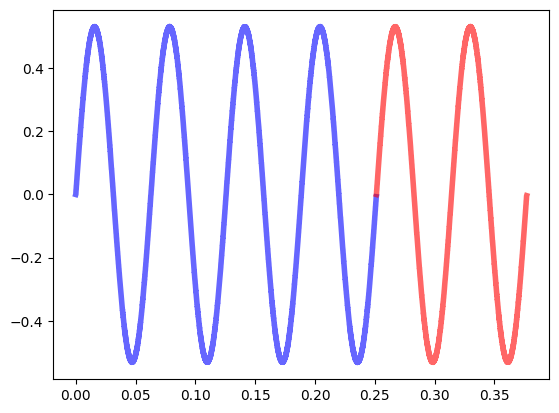

In [17]:
# plot data without noise
plt.plot(t_train[:,0], w_train[:,0], label="Exact solution", color="blue", alpha=0.6, linewidth=4)
plt.plot(t_test[:,0], w_test[:,0], label="Exact solution", color="red", alpha=0.6,  linewidth=4)

# plot data with noise
# plt.scatter(t_train[:,0], w_train_noise, label='Training data', color='blue', alpha=0.7)
# plt.scatter(t_test[:,0], w_test_noise, label='Testing data', color='red', alpha=0.7)

In [18]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self,x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

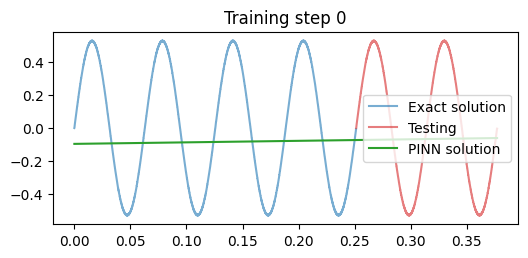

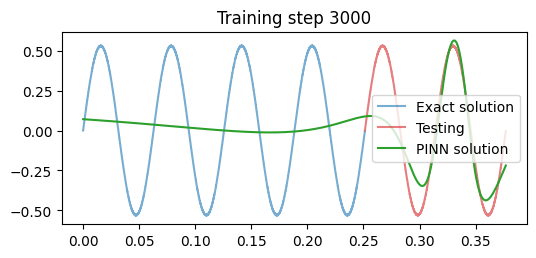

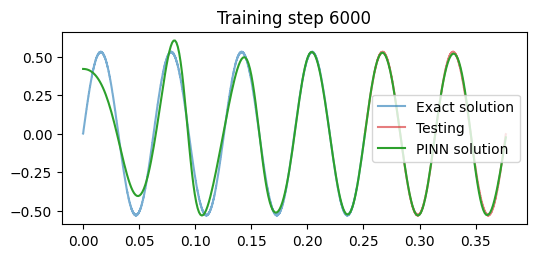

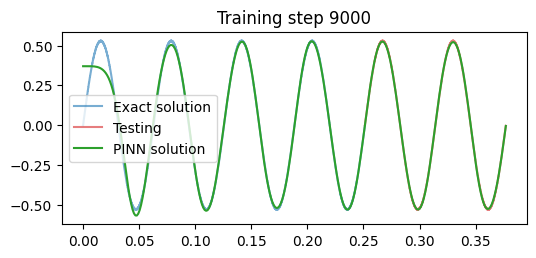

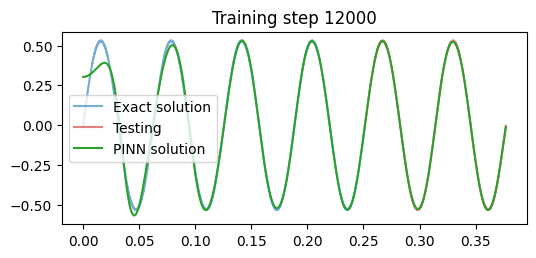

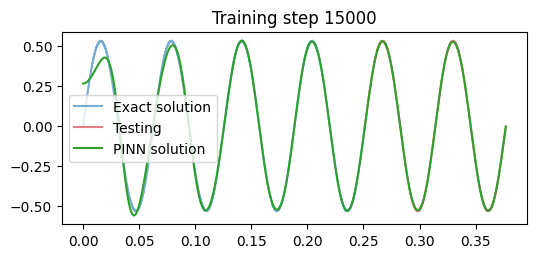

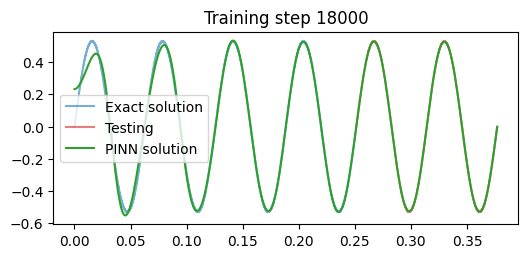

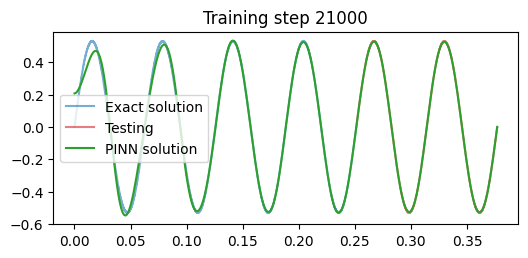

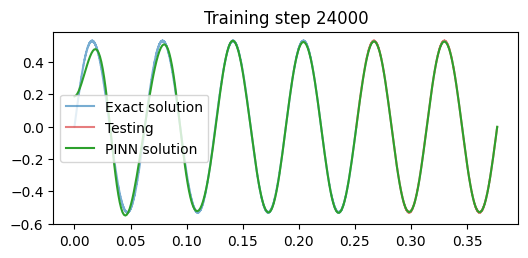

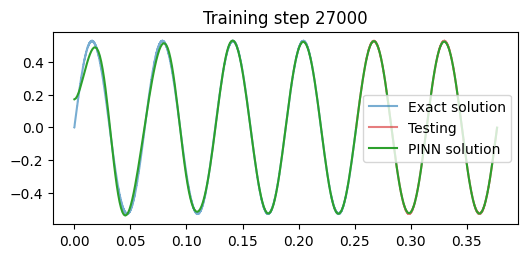

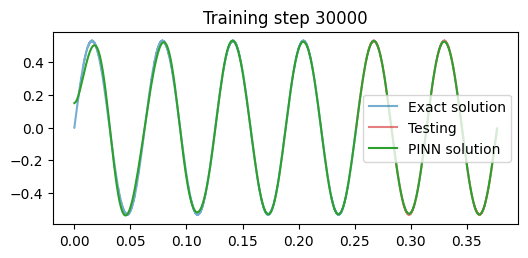

In [23]:
torch.manual_seed(123)
# Specify model architecture
pinn = FCN(1,1,16,2)

# Define boundary points for the boundary loss
t_0 = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,(3.14159265359/50)*6,400).view(-1, 1).requires_grad_(True)

# Train the PINN
u_exact = w_train

# ODE parameter
k=10**4
I3=0.128084294660844/k
I4=0.025616858932169/k
a1=-6.545610677194445e+07/k
a3=-4.693008087966169e+12/(k**3)

optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)
losss=[]
losss1=[]
losss2=[]
losss3=[]
losss4=[]
iterations = []
for i in range(30001):
    optimiser.zero_grad()
    lambda1, lambda2, lambda3, lambda4= 1, 1, 1e-5, 1
    # Compute the boudary loss
    u = pinn(t_0)
    loss1 = (torch.squeeze(u) - 0)**2

    dudt = torch.autograd.grad(u, t_0, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt)-0)**2

    # Compute the physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    M38=0.034651844804272
    q=(10**5)*M38*torch.sin(100*t_physics)
    loss3 = torch.mean((I3*d2udt2+I4*dudt-a1*u-a3*u**3-q)**2)

    # Compute the "data loss"
    w_out = pinn(t_train)
    loss4 = torch.mean((w_out-u_exact)**2) # use mean squared error

    # Backpropagate joint loss, take optimiser step
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4*loss4

    loss.backward()
    optimiser.step()

    thoigian=torch.linspace(0,(3.14159265359/50)*6,300).view(-1,1)
    # plot the result as training progresses
    if i % 3000 == 0:
        u = pinn(thoigian).detach()

        losss.append(loss)
        losss1.append(lambda1*loss1)
        losss2.append(lambda2*loss2)
        losss3.append(lambda3*loss3)
        losss4.append(lambda4*loss4)
        iterations.append(i)
        plt.figure(figsize=(6,2.5))
        # plt.scatter(t_physics.detach()[:,0],torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        # plt.scatter(t_0.detach()[:,0],torch.zeros_like(t_0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)

        # plt.scatter(t_train[:,0], w_train_noise, label='Training data', color='blue', alpha=0.7)
        # plt.scatter(t_test[:,0], w_test_noise, label='Testing data', color='red', alpha=0.7)

        plt.plot(t_train[:,0], w_train[:,0], label="Exact solution", color="tab:blue", alpha=0.6)
        plt.plot(t_test[:,0], w_test[:,0], label="Testing", color="tab:red", alpha=0.6)
        plt.plot(thoigian[:,0], u[:,0], label="PINN solution", color="tab:green")


        plt.title(f"Training step {i}")
        plt.legend()

        plt.show()

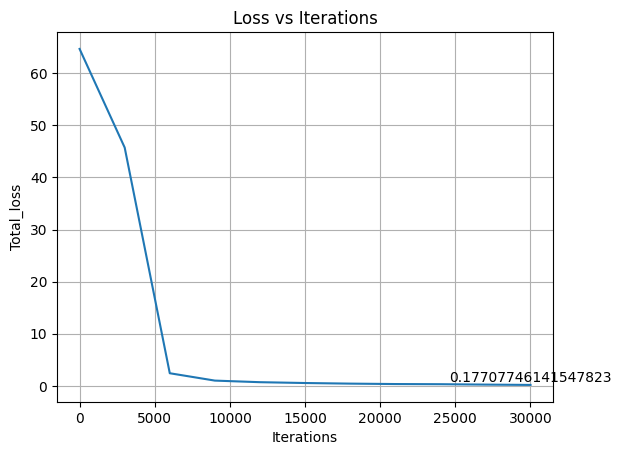

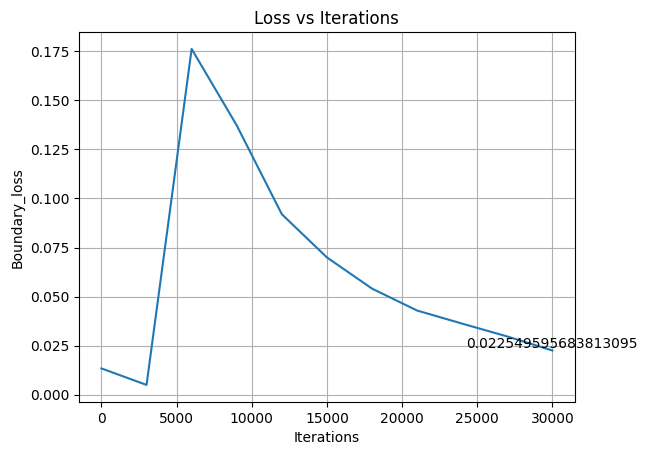

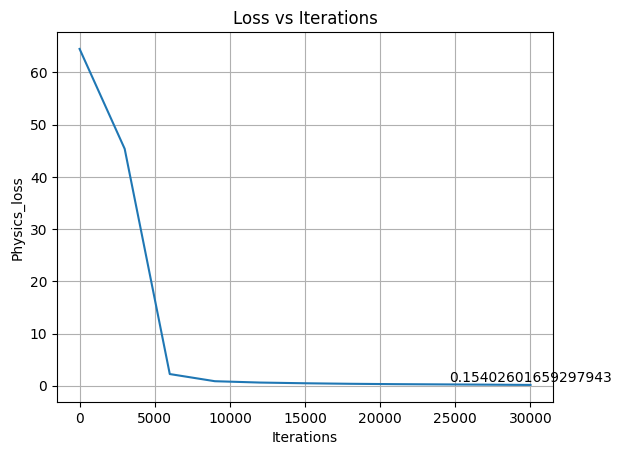

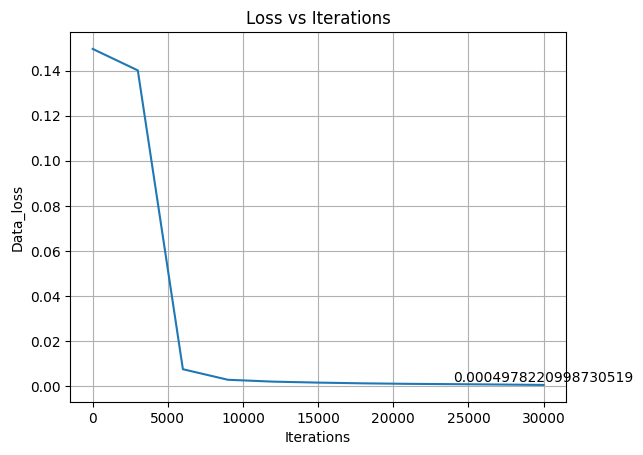

In [24]:
# Print losses

lossss = [tensor.tolist() for tensor in losss]
lossss = [element for element in lossss]
lossss1 = [tensor.tolist() for tensor in losss1]

lossss3 = [tensor.tolist() for tensor in losss3]
lossss4 = [tensor.tolist() for tensor in losss4]

plt.figure(1)
plt.plot(iterations, lossss)
plt.xlabel('Iterations')
plt.ylabel('Total_loss')
plt.title('Loss vs Iterations')

last_index = len(iterations) - 1
# last_index = 0
last_number = lossss[last_index]
plt.text(iterations[last_index], last_number, str(last_number), ha='center', va='bottom')
plt.grid()
############
plt.figure(2)
plt.plot(iterations, lossss1)
plt.xlabel('Iterations')
plt.ylabel('Boundary_loss')
plt.title('Loss vs Iterations')

last_index = len(iterations) - 1
# last_index = 0
last_number = lossss1[last_index]
plt.text(iterations[last_index], last_number, str(last_number), ha='center', va='bottom')
plt.grid()
########
plt.figure(3)
plt.plot(iterations, lossss3)
plt.xlabel('Iterations')
plt.ylabel('Physics_loss')
plt.title('Loss vs Iterations')

last_index = len(iterations) - 1
# last_index = 0
last_number = lossss3[last_index]
plt.text(iterations[last_index], last_number, str(last_number), ha='center', va='bottom')
plt.grid()
############
plt.figure(4)

plt.plot(iterations, lossss4)
plt.xlabel('Iterations')
plt.ylabel('Data_loss')
plt.title('Loss vs Iterations')

last_index = len(iterations) - 1

# last_index = 0
last_number = lossss4[last_index]
plt.text(iterations[last_index], last_number, str(last_number), ha='center', va='bottom')
plt.grid()

plt.show()

In [26]:
# R-squared score, in this section you have to true_values file
from sklearn.metrics import r2_score

predicted_values = pinn(thoigian).detach().numpy()
#########
data_true=pd.read_excel('true_values.xlsx',header=None)
data_true1=data_true.iloc[:,0]
data_true2=torch.tensor(data_true1).view(-1,1)
data_true2=data_true2*10**4

true_values =  data_true2.numpy()

# # Calculate the R1 score
r1_score = r2_score(true_values, predicted_values)

print("R1 score:", r1_score)
# print(data_true1.shape)

In [ ]:
# Save data
import csv
data1=thoigian.numpy()
data2=pinn(thoigian).detach().numpy()
# Path to the CSV file
csv_file_path = 't_pre.csv'

# Open the file in write mode and create a CSV writer object
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the data to the CSV file
    writer.writerows(data1)

print("Data written to CSV file successfully.")

Data written to CSV file successfully.


In [ ]:
# Save model
torch.save(pinn, 'pinn_model.pth')

Elapsed time: 0.02641153335571289 seconds


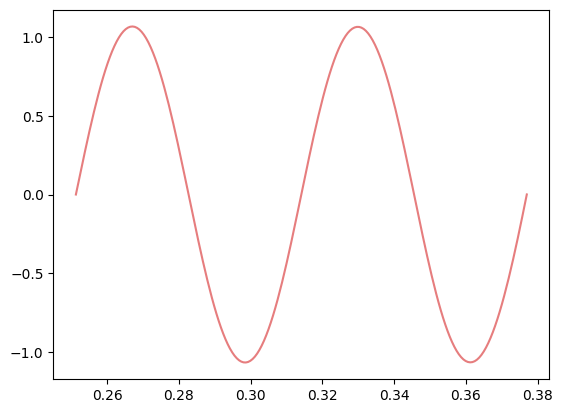

In [ ]:
# Calculate the computational time
import time
# load model
model = torch.load('pinn_model.pth')
start_time = time.time()

thoigian_test=torch.linspace((3.14159265359/50)*4,(3.14159265359/50)*6,200).view(-1,1)
W_predicted=model(thoigian_test).detach()
plt.plot(thoigian_test, W_predicted, label="Ode_solution", color="tab:red", alpha=0.6)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")